In [137]:
import pathlib

from astropy.constants import G
import astropy.table as at
from astropy.convolution import convolve, Gaussian2DKernel
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import gala.dynamics as gd
import gala.integrate as gi
from gala.units import galactic
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d
from scipy.interpolate import interp1d
import cmasher as cmr
import seaborn as sns

import agama
from pyia import GaiaData

from config import galcen_frame, R0, vc0, gala_pot, agama_pot

agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

In [2]:
figure_path = pathlib.Path("../tex/figures/").resolve()

In [3]:
tmp1 = at.Table.read(
    "/mnt/home/apricewhelan/data/APOGEE/DR17/allStar-dr17-synspec-gaiadr3-gaiasourcelite.fits"
)
tmp2 = at.Table.read(
    "/mnt/home/apricewhelan/data/APOGEE/DR17/allStarLite-dr17-synspec_rev1.fits"
)
apogee = at.join(tmp2, tmp1, keys="APOGEE_ID")
apogee = at.unique(apogee, keys="APOGEE_ID")
apogee = GaiaData(apogee)

In [4]:
apogee = apogee.filter(
    # LOGG=(0.5, 3),
    LOGG=(1.5, 3),
    TEFF=(3000, 5500),
    FE_H=(-0.8, 0.5),
    MG_FE=(-0.2, 0.22),
    parallax=(0.0 * u.mas, None),
)

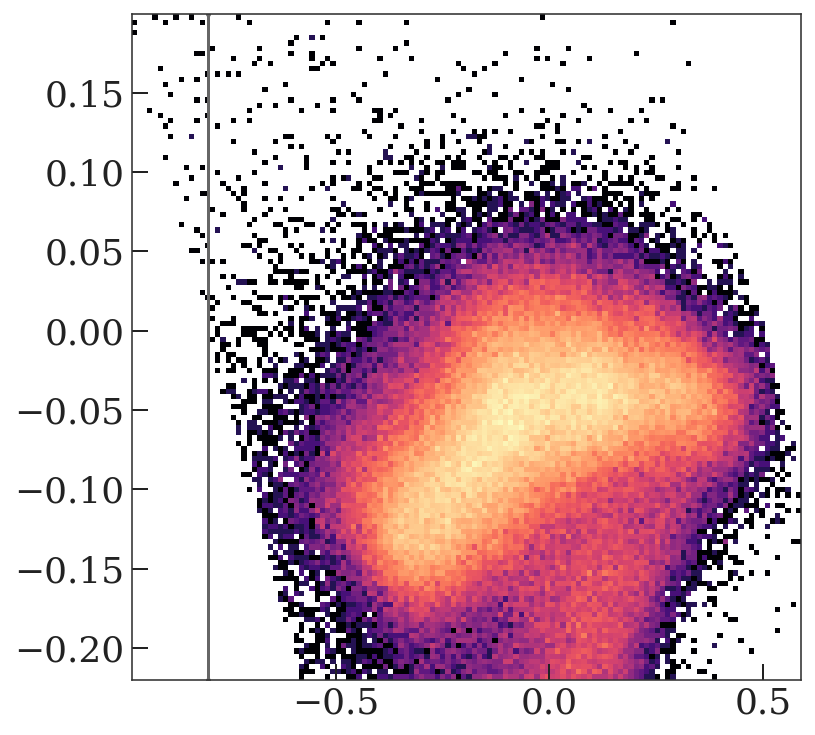

In [5]:
# plt.hist2d(
#     apogee['FE_H'],
#     apogee['MG_FE'],
#     bins=128,
#     norm=mpl.colors.LogNorm()
# );
# plt.axvline(-0.8)
# plt.axhline(0.22)

plt.hist2d(
    apogee["MG_FE"] + apogee["FE_H"],
    -apogee["MG_FE"],
    bins=128,
    norm=mpl.colors.LogNorm(),
)
plt.axvline(-0.8)
plt.axhline(0.22)

In [6]:
c_ap = apogee.get_skycoord(radial_velocity=apogee.VHELIO_AVG * u.km / u.s)
galcen_ap = c_ap.transform_to(galcen_frame)
w_ap = gd.PhaseSpacePosition(galcen_ap.data)

In [7]:
# Lz_sun = R0*vc0
Lz_sun = R0 * 229 * u.km / u.s
print(Lz_sun)
Lz = np.abs(w_ap.angular_momentum()[2]).to(u.kpc * u.km / u.s)
Lz_mask = np.abs(Lz - Lz_sun) < 0.15 * Lz_sun
Lz_mask.sum()

1894.9750000000001 km kpc / s


63601

In [8]:
bins = (np.linspace(-100, 100, 128), np.linspace(-2.5, 2.5, 128))

stat = binned_statistic_2d(
    galcen_ap.v_z.to_value(u.km / u.s)[Lz_mask],
    galcen_ap.z.to_value(u.kpc)[Lz_mask],
    apogee.MG_FE[Lz_mask],
    bins=bins,
    statistic="mean",
)

counts, *_ = np.histogram2d(
    galcen_ap.v_z.to_value(u.km / u.s)[Lz_mask],
    galcen_ap.z.to_value(u.kpc)[Lz_mask],
    bins=bins,
)

Make orbits:

In [53]:
# # A grid spaced in Jz:

# JR = 0. * u.kpc**2/u.Myr
# Jphi = Lz_sun

# Norbits = 8
# orbits = []
# zvzs = []

# Nt = 1024
# zeros = np.zeros(Nt)

# Jzs = np.linspace(1e-2, np.sqrt(0.06), Norbits) ** 2 * u.kpc**2 / u.Myr
# zmaxs = []
# Omzs = []
# for Jz in Jzs:
#     act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
#     torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-7)
#     Omzs.append(torus_mapper.Omegaz)

#     T = 2 * np.pi / torus_mapper.Omegaz
#     t_grid = np.linspace(0, T, Nt)

#     xv0 = torus_mapper([0.,0,0]).T
# #     print(xv0)
#     orbit = gala_pot.integrate_orbit(xv0, t=t_grid, Integrator=gi.DOPRI853Integrator)
#     zvzs.append((orbit.z.to_value(u.kpc), orbit.v_z.to_value(u.km/u.s)))
#     zmaxs.append(orbit.z.to_value(u.kpc).max())
#     orbits.append(orbit)

# cmap_Jz = cmr.get_sub_cmap(cmr.ocean, 0.2, 0.8)
# norm_Jz = mpl.colors.Normalize(
#     vmin=0.,
#     vmax=10.,
# )

### Orbits spaced in zmax:

In [77]:
JR = 0.0 * u.kpc**2 / u.Myr
Jphi = Lz_sun

act = u.Quantity([JR, 1e-8 * JR.unit, Jphi]).to_value(u.kpc**2 / u.Myr)
torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-10)
Omega0 = torus_mapper.Omegaz * u.rad / u.Myr
Omega0

<Quantity 0.07819996 rad / Myr>

In [133]:
tmp_zmax = [0.05, 2.0] * u.kpc
tmp_Jz = (0.5 * Omega0 * tmp_zmax**2).to(u.km / u.s * u.kpc, u.dimensionless_angles())

# tmp_Jzs = np.linspace(0.5 * tmp_Jz[0].value, 2 * tmp_Jz[1].value, 128) * tmp_Jz.unit
tmp_Jzs = (
    np.linspace(np.sqrt(0.5 * tmp_Jz[0].value), np.sqrt(2 * tmp_Jz[1].value), 128) ** 2
    * tmp_Jz.unit
)

tmp_zs = np.zeros(tmp_Jzs.size)
for i, Jz in enumerate(tmp_Jzs):
    act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
    torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-10)
    xv0 = torus_mapper([0.0, np.pi / 2, 0]).T
    tmp_zs[i] = xv0[2]

zmax_to_Jz = interp1d(tmp_zs, tmp_Jzs.value)
zmax_grid = np.arange(0.1, 2 + 1e-3, 0.3)
Jz_grid = zmax_to_Jz(zmax_grid) * tmp_Jzs.unit
zmax_grid

array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9])

In [147]:
orbits = []
zvzs = []

Nt = 1024
zeros = np.zeros(Nt)

Omzs = []
for Jz in Jz_grid:
    act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
    torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-10)
    Omzs.append(torus_mapper.Omegaz)

    T = 2 * np.pi / torus_mapper.Omegaz
    t_grid = np.linspace(0, T, Nt)

    xv0 = torus_mapper([0.0, 0, 0]).T
    orbit = gala_pot.integrate_orbit(xv0, t=t_grid, Integrator=gi.DOPRI853Integrator)
    zvzs.append((orbit.z.to_value(u.kpc), orbit.v_z.to_value(u.km / u.s)))
    orbits.append(orbit)

# cmap_zmax = cmr.get_sub_cmap(cmr.emerald, 0.05, 1.)
cmap_zmax = cmr.get_sub_cmap(plt.get_cmap("viridis"), 0.4, 0.9)
norm_zmax = mpl.colors.Normalize(
    vmin=zmax_grid.min(),
    vmax=zmax_grid.max(),
)
# [x[0].max() for x in zvzs]
len(zmax_grid)

7

25732
std 0.051122997


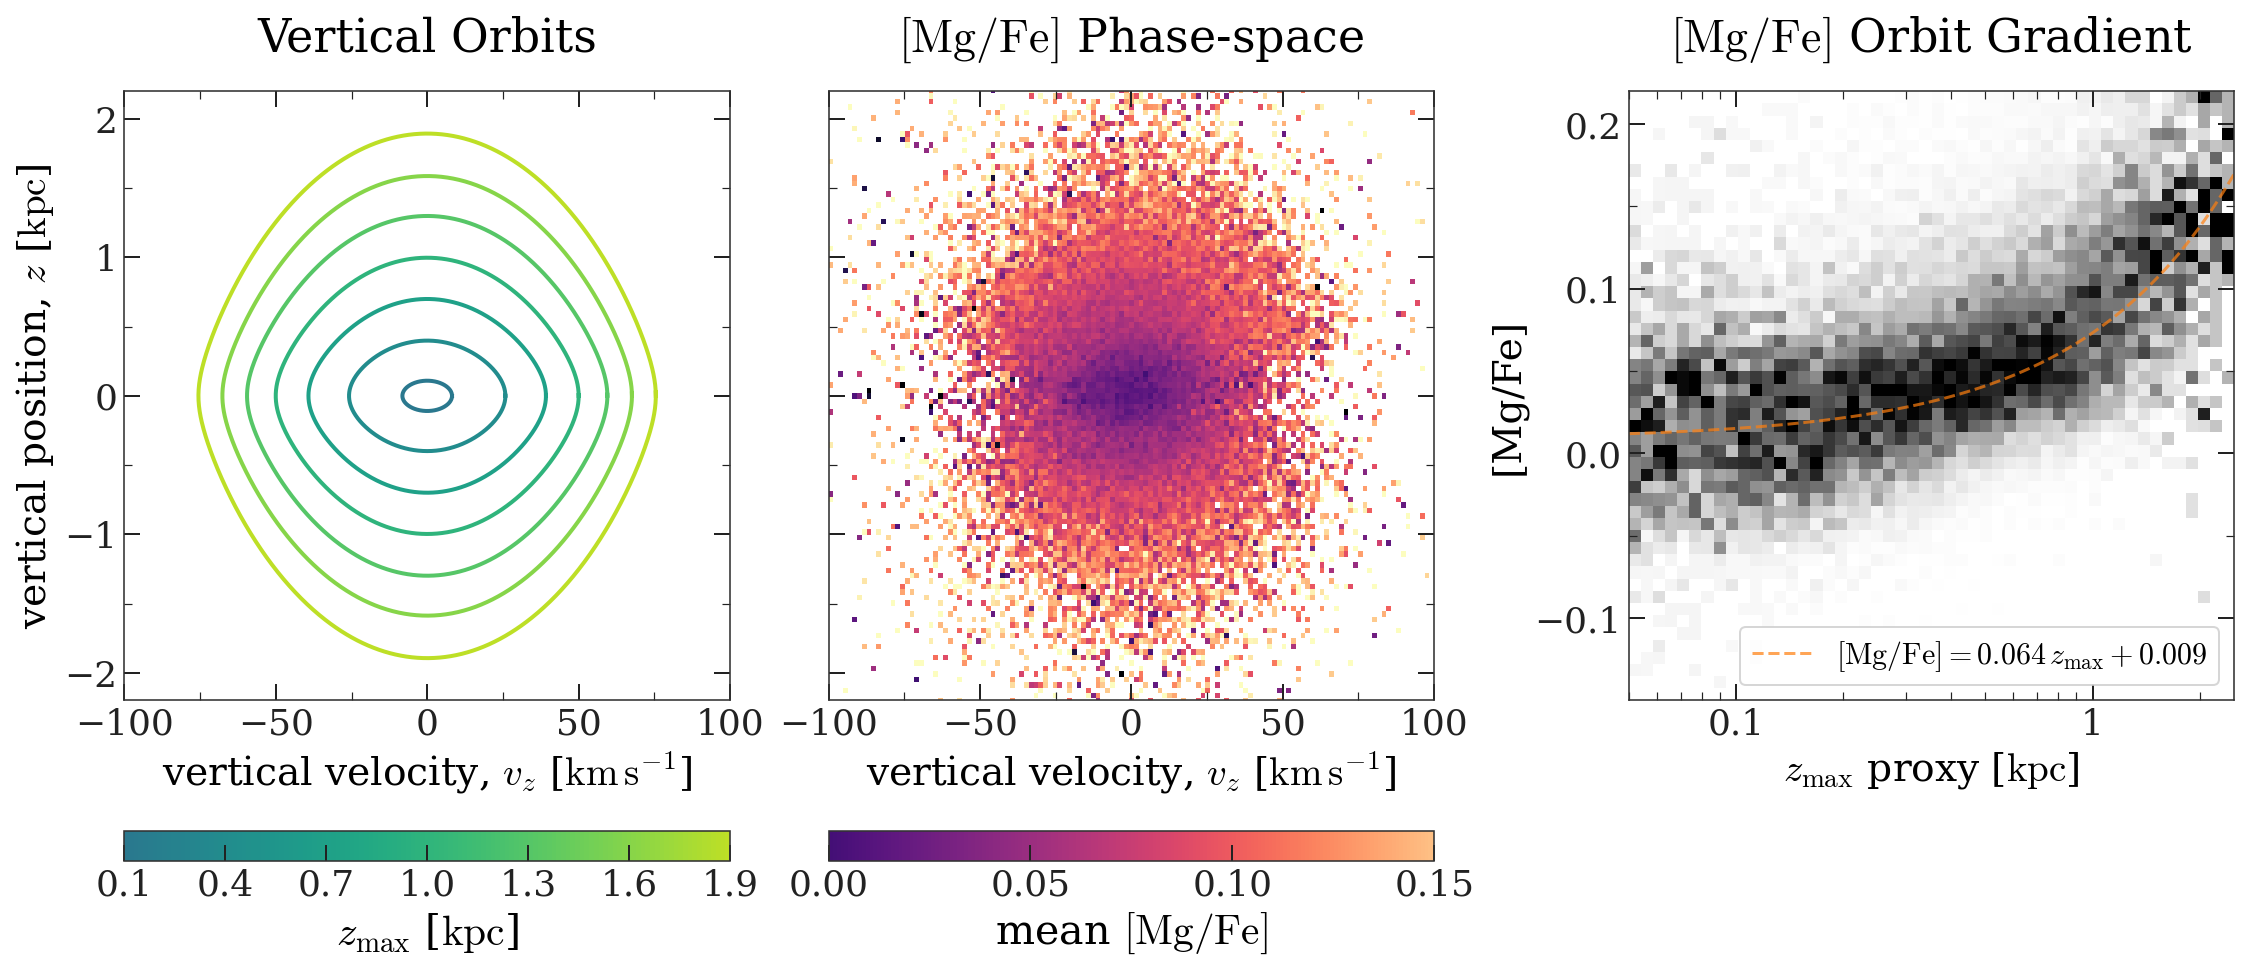

In [181]:
zmax_mask = Lz_mask & (np.abs(galcen_ap.v_z) < 10 * u.km / u.s)
print(zmax_mask.sum())

titlesize = 23
title_kw = dict(fontsize=titlesize, pad=20)
label_kw = dict(fontsize=0.85 * titlesize)

vzlim = (-100, 100)
zlim = (-2.2, 2.2)

hline_val = np.nanmedian(apogee.MG_FE[zmax_mask & (np.abs(galcen_ap.z) < 200 * u.pc)])
print("std", np.nanstd(apogee.MG_FE[zmax_mask & (np.abs(galcen_ap.z) < 200 * u.pc)]))

fig, axes = plt.subplots(1, 3, figsize=(15.5, 6.6), constrained_layout=True)

ax = axes[0]

for (z, vz), zmax in zip(zvzs, zmax_grid):
    ax.plot(vz, z, marker="", ls="-", lw=2, color=cmap_zmax(norm_zmax(zmax)))

ax.set_title(r"Vertical Orbits", **title_kw)

ax.set_xlabel(f"vertical velocity, $v_z$ [{u.km/u.s:latex_inline}]", **label_kw)
ax.set_ylabel(f"vertical position, $z$ [{u.kpc:latex_inline}]", **label_kw)

sm = plt.cm.ScalarMappable(cmap=cmap_zmax, norm=norm_zmax)
sm.set_array([])
cb = fig.colorbar(sm, ax=axes[0], orientation="horizontal")
cb.set_label(r"$z_{\rm max}$ " + f"[{u.kpc:latex}]", fontsize=0.9 * titlesize)
cb.set_ticks(zmax_grid)

# ---

ax = axes[1]

cs = ax.pcolormesh(
    stat.x_edge,
    stat.y_edge,
    stat.statistic.T,
    cmap="magma",
    vmin=-0.05,
    vmax=0.18,
    rasterized=True,
)
# for val in [-10, 10.]:
#     ax.axvline(val, color='#aaaaaa', alpha=0.75, ls='-')

ax.set_xlabel(f"vertical velocity, $v_z$ [{u.km/u.s:latex_inline}]", **label_kw)
# ax.set_ylabel(f"vertical position, $z$ [{u.kpc:latex_inline}]", **label_kw)

cb = fig.colorbar(cs, ax=ax, orientation="horizontal")
cb.set_label(r"mean $[{\rm Mg}/{\rm Fe}]$", fontsize=0.9 * titlesize)
cb.ax.set_xlim(0.0, 0.15)

ax.set_title(r"$[{\rm Mg}/{\rm Fe}]$ Phase-space", **title_kw)

axes[1].sharex(axes[0])
axes[1].sharey(axes[0])
axes[1].tick_params(labelleft=False)
axes[1].set_xlim(vzlim)
axes[1].set_ylim(zlim)

for ax in axes:
    ax.set_xticks(np.arange(-100, 100 + 1, 50))
    ax.set_xticks(np.arange(-100, 100 + 1, 25), minor=True)

    ax.set_yticks(np.arange(-2, 2 + 1e-3, 1))
    ax.set_yticks(np.arange(-2, 2 + 1e-3, 0.5), minor=True)

# ---

ax = axes[2]

H, xe, ye = np.histogram2d(
    np.abs(galcen_ap.z.to_value(u.kpc)[zmax_mask]),
    apogee.MG_FE[zmax_mask],
    bins=(np.geomspace(*xlim, 51), np.linspace(*ylim, 51)),
)
ax.pcolormesh(
    xe, ye, H.T / H.T.sum(axis=0)[None], vmax=0.08, cmap="Greys", rasterized=True
)

grid = np.linspace(*xlim, 256)
slope = (0.17 - hline_val) / (2.5 - 0.15)
offset = hline_val - slope * 0.15
ax.plot(
    grid,
    slope * grid + offset,
    ls="--",
    marker="",
    alpha=0.7,
    color="tab:orange",
    lw=1.5,
    label=r"$[{\rm Mg}/{\rm Fe}] = "
    + f"{slope:0.3f}\,"
    + r"z_{\rm max}"
    + f" + {offset:0.3f}$",
)

ax.legend(loc="lower right", fontsize=15)
ax.set_xlim(0.05, 2.5)
ax.set_xscale("log")
ax.set_ylim(-0.15, 0.22)

ax.set_xticks([1e-1, 1e0])
ax.set_xticklabels(["0.1", "1"])

ax.set_xlabel(r"$z_{\rm max}$ proxy " + f"[{u.kpc:latex_inline}]", **label_kw)
ax.set_ylabel(r"[Mg/Fe]", **label_kw)
ax.set_yticks(np.arange(-0.1, 0.2 + 1e-3, 0.1))
ax.set_yticks(np.arange(-0.1, 0.2 + 1e-3, 0.05), minor=True)

ax.set_title(r"$[{\rm Mg}/{\rm Fe}]$ Orbit Gradient", **title_kw)

# fig.suptitle(
#     "Observed Element Abundance Gradient and Orbit Shapes", fontsize=26
# )

for ax in axes:
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

fig.savefig(figure_path / "mgfe-zvz.pdf", dpi=300)

# Fourier version of orbits

Fit an orbit shape explicitly with a Fourier expansion

In [255]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt

In [360]:
def get_rzp(p, thp):
    """
    This is a series expansion of the inverse of the expression defining
    rz in terms of rzp, assuming that the e_m functions are linear functions
    of rzp.
    """
    rz, a2, a4 = p
    a = a2 * jnp.cos(2 * thp) + a4 * jnp.cos(4 * thp)
    c = rz
    return (
        c
        - c**2 * a
        + 2 * c**3 * a**2
        - 5 * c**4 * a**3
        + 14 * c**5 * a**4
        - 42 * c**6 * a**5
    )


@jax.jit
def obj(p, rzp, thp):
    model_rzp = get_rzp(p, thp)
    return np.sum((rzp - model_rzp) ** 2) / len(rzp)


def get_zvz(p, thp, Omega):
    rzp = get_rzp(p, thp)
    z = rzp / np.sqrt(Omega) * np.sin(thp)
    vz = rzp * np.sqrt(Omega) * np.cos(thp)
    return z, vz


def get_thp_rzp(orbit, Omega0):
    with u.set_enabled_equivalencies(u.dimensionless_angles()):
        rzp = np.sqrt(orbit.z**2 * Omega0 + orbit.v_z**2 / Omega0)
        thp = np.arctan2(orbit.z * np.sqrt(Omega0), orbit.v_z / np.sqrt(Omega0))

    idx = np.argsort(thp)
    thp = thp[idx]
    rzp = rzp[idx]

    return thp, rzp


def fit_orbit(orbit, Omega0):
    thp, rzp = get_thp_rzp(orbit, Omega0)

    opt = jaxopt.ScipyBoundedMinimize(fun=obj)
    p0 = [np.mean(rzp), 1e-5, 1e-5]
    res = opt.run(p0, rzp=rzp, thp=thp, bounds=([0.0, -1, -1], [1.0, 1, 1]))
    if not res.state.success:
        print("FAILED", res.state)

    return res.params

In [368]:
fitted_zvzs = []
fitted_thp_rzps = []
fit_ps = []
for orbit in orbits:
    p = fit_orbit(orbit, Omega0)
    fit_ps.append(p)

    thp_grid = np.linspace(-np.pi, np.pi, 1024)
    rzp_grid = get_rzp(p, thp_grid)
    fitted_thp_rzps.append((thp_grid, rzp_grid))

    zz, vv = get_zvz(p, thp_grid, Omega0.value)
    fitted_zvzs.append((zz, vv))

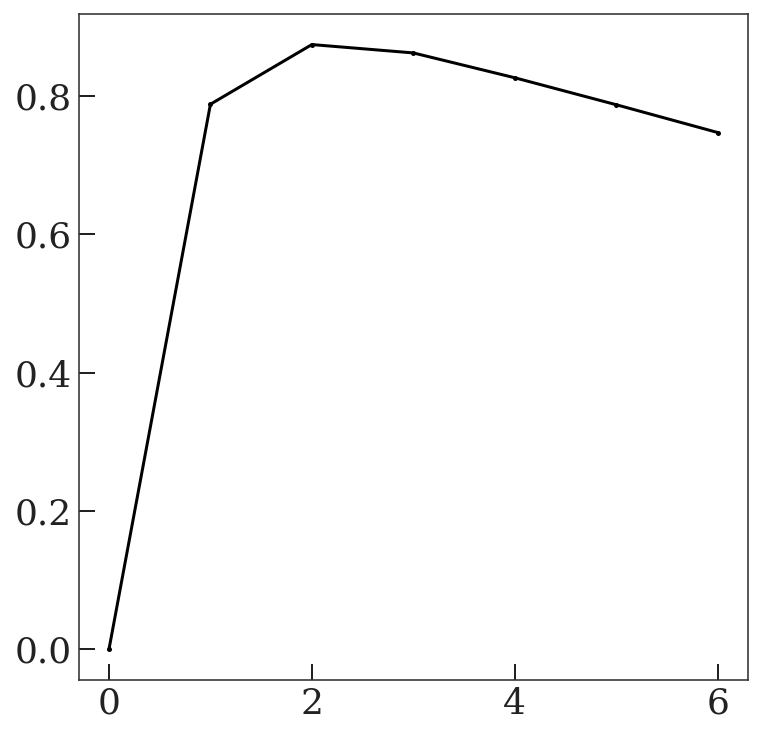

In [359]:
plt.plot([x[1] for x in fit_ps])

In [369]:
def pi_ticklabel(val, denomlim=10):
    """
    format label properly
    for example: 0.6666 pi --> 2π/3
               : 0      pi --> 0
               : 0.50   pi --> π/2
    """
    from fractions import Fraction

    minus = "-" if val < 0 else ""
    val = abs(val)
    ratio = Fraction(val / np.pi).limit_denominator(denomlim)
    n, d = ratio.numerator, ratio.denominator

    pi = r"\pi"
    fmt2 = f"{d:d}"
    if n == 0:
        fmt1 = "0"
    elif n == 1:
        fmt1 = pi
    else:
        fmt1 = f"{n:d}{pi}"

    txt = fmt1 if d == 1 else f"{fmt1}/{fmt2}"

    return f"${minus}{txt}$"

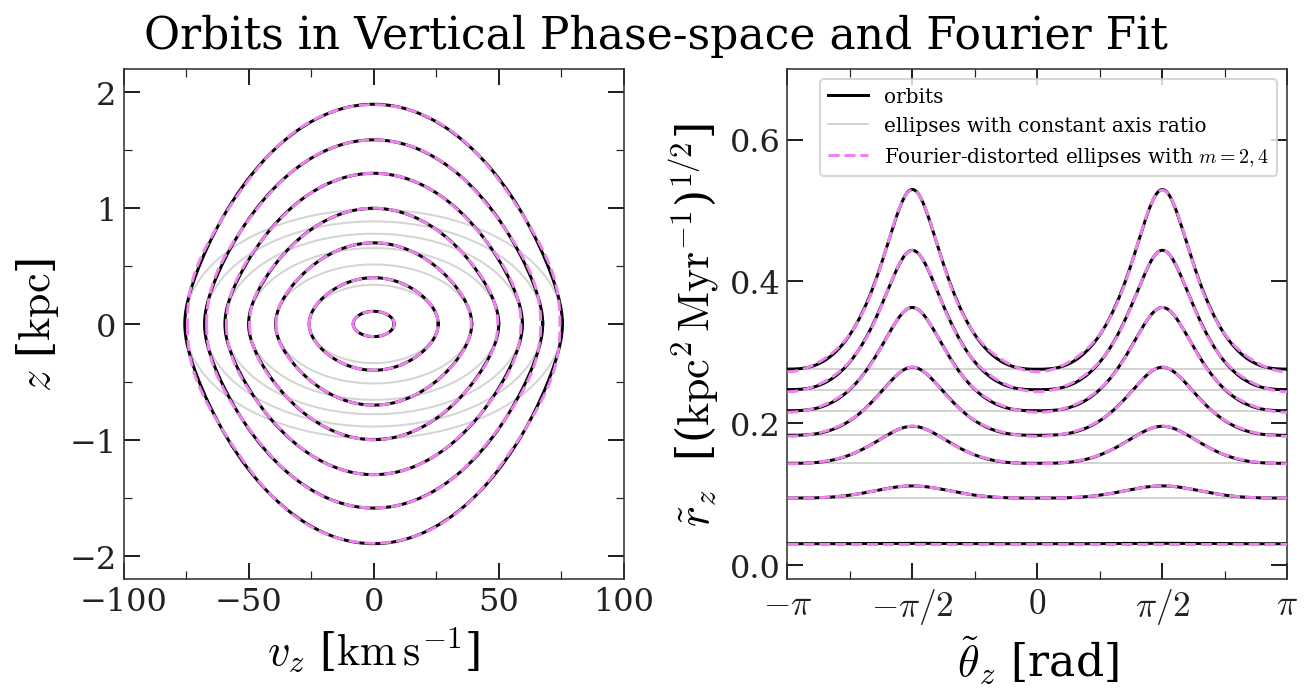

In [372]:
tick_size = 16

fig, axes = plt.subplots(
    1,
    2,
    figsize=(9, 4.75),
    constrained_layout=True,
)

ax = axes[0]
orbit_linestyle = dict(marker="", ls="-", lw=1.5, color="k", zorder=10, label="orbits")
ellip_linestyle = dict(
    marker="",
    ls="-",
    lw=1.0,
    alpha=0.5,
    color="#aaaaaa",
    zorder=-10,
    label="ellipses with constant axis ratio",
)
fourier_linestyle = dict(
    marker="",
    ls="--",
    lw=1.5,
    color="violet",
    zorder=20,
    label="Fourier-distorted ellipses with $m={2,4}$",
)
for orbit, Jz, (fit_z, fit_vz), (fit_thp, fit_rzp) in zip(
    orbits, Jz_grid, fitted_zvzs, fitted_thp_rzps
):
    axes[0].plot(orbit.v_z.to_value(u.km / u.s), orbit.z.value, **orbit_linestyle)

    thp, rzp = get_thp_rzp(orbit, Omega0)
    axes[1].plot(thp, rzp.decompose(galactic).value, **orbit_linestyle)

    # Ellipses with constant aspect ratio:
    idx = np.abs(thp - 0 * u.rad).argmin()
    th_grid = np.linspace(-np.pi, np.pi, 1024)
    with u.set_enabled_equivalencies(u.dimensionless_angles()):
        z_grid = (rzp[idx] / np.sqrt(Omega0)).to(u.kpc) * np.sin(th_grid)
        vz_grid = (rzp[idx] * np.sqrt(Omega0)).to(u.km / u.s) * np.cos(th_grid)

    axes[0].plot(vz_grid, z_grid, **ellip_linestyle)
    axes[1].plot(
        th_grid,
        np.full_like(th_grid, rzp[idx].decompose(galactic).value),
        **ellip_linestyle,
    )

    # Fourier exp:
    axes[0].plot(
        (fit_vz * u.kpc / u.Myr).to_value(u.km / u.s),
        fit_z,
        **fourier_linestyle,
    )
    axes[1].plot(fit_thp, fit_rzp, **fourier_linestyle)

    for style in [orbit_linestyle, ellip_linestyle, fourier_linestyle]:
        style.pop("label", None)


axes[1].legend()

# Labels:
axes[0].set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
axes[1].set_xlabel(r"$\tilde{\theta}_z$ [rad]")
rz2_unit = u.kpc**2 / u.Myr
axes[1].set_ylabel(
    r"$\tilde{r}_z$ " + f" [({rz2_unit.to_string(format='latex_inline')})$^{{1/2}}$]"
)

# Ticks:
axes[0].xaxis.set_tick_params(labelsize=tick_size)
axes[0].set_xticks(np.arange(-100, 100 + 1, 50))
axes[0].set_xticks(np.arange(-100, 100 + 1, 25), minor=True)
axes[0].yaxis.set_tick_params(labelsize=tick_size)
axes[0].set_yticks(np.arange(-3, 3 + 1e-3, 1))
axes[0].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

axes[1].xaxis.set_tick_params(labelsize=1.1 * tick_size)
_ticks = np.arange(-1, 1 + 1e-3, 0.5) * np.pi
axes[1].set_xticks(_ticks)
axes[1].set_xticklabels([pi_ticklabel(val) for val in _ticks])
axes[1].set_xticks(np.arange(-1, 1 + 1e-3, 0.25) * np.pi, minor=True)
axes[1].yaxis.set_tick_params(labelsize=tick_size)
# axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 1))
# axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

# Limits:
axes[0].set_xlim(vzlim)
axes[0].set_ylim(zlim)
axes[1].set_xlim(-np.pi, np.pi)
axes[1].set_ylim(-0.02, 0.7)

# Titles:
title_size = 18
# axes[0].set_title("Orbits", fontsize=title_size)
fig.suptitle("Orbits in Vertical Phase-space and Fourier Fit", fontsize=22)

# Aspect and padding:
# axes[0].set_aspect(100.0 / 3)

for ax in axes:
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

fig.savefig(figure_path / "simulated-orbits-fourier.pdf")

---

OLDER STUFF BELOW

25732
std 0.051122997


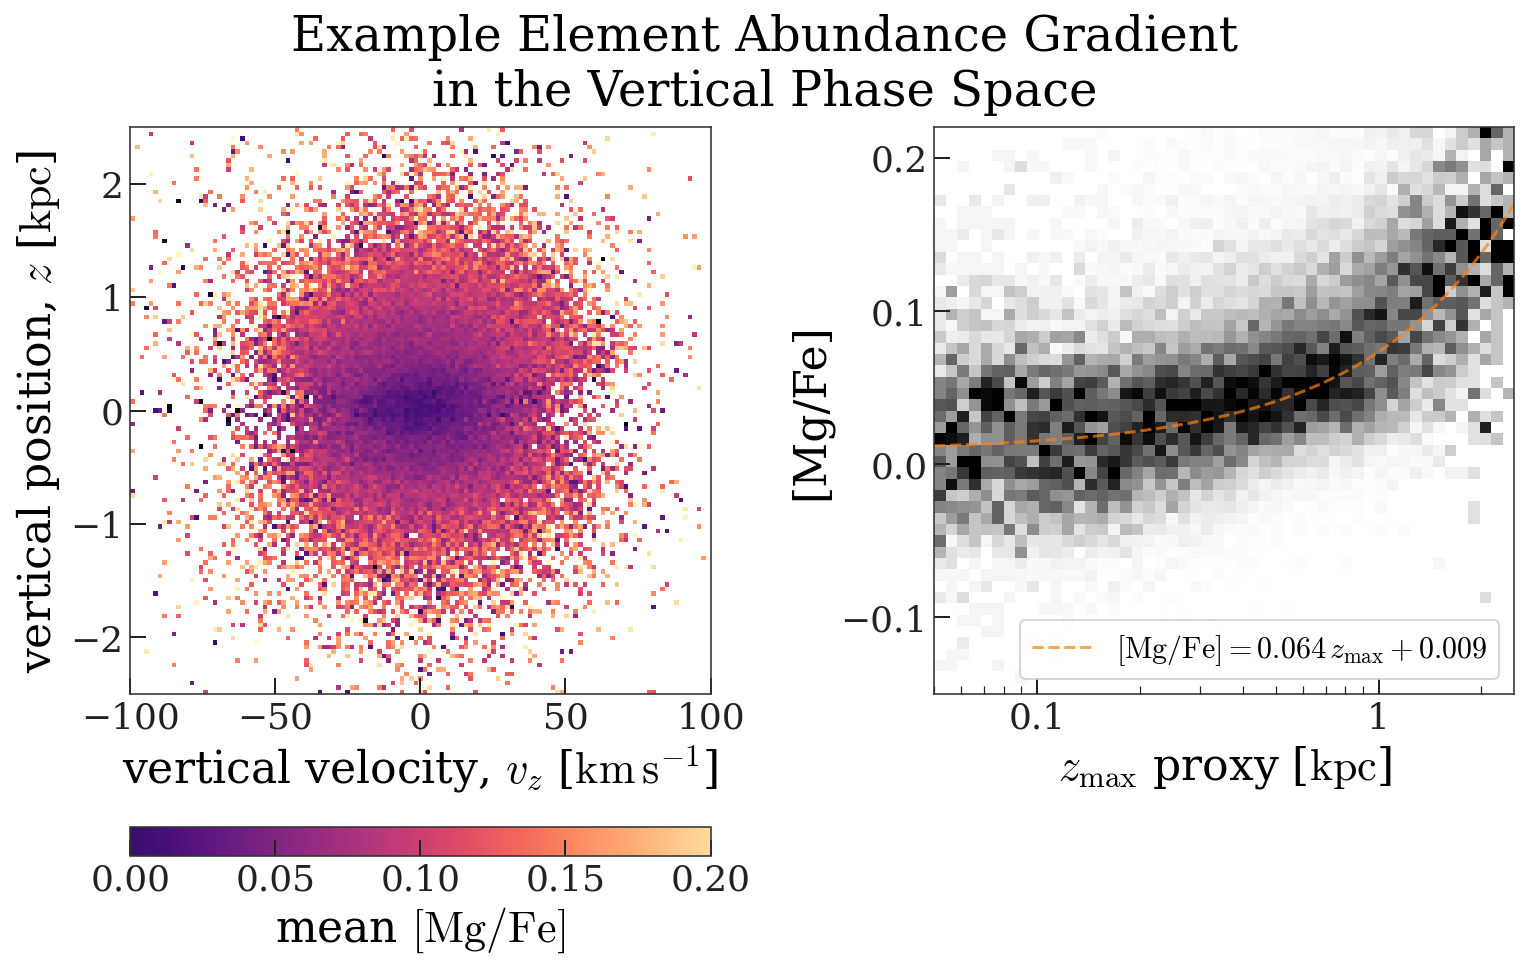

In [12]:
zmax_mask = Lz_mask & (np.abs(galcen_ap.v_z) < 10 * u.km / u.s)
print(zmax_mask.sum())

xlim = (0.05, 2.5)
ylim = (-0.15, 0.22)

hline_val = np.nanmedian(apogee.MG_FE[zmax_mask & (np.abs(galcen_ap.z) < 200 * u.pc)])
print("std", np.nanstd(apogee.MG_FE[zmax_mask & (np.abs(galcen_ap.z) < 200 * u.pc)]))

fig, axes = plt.subplots(1, 2, figsize=(10.5, 6.6), constrained_layout=True)

ax = axes[0]

cs = ax.pcolormesh(
    stat.x_edge,
    stat.y_edge,
    stat.statistic.T,
    cmap="magma",
    vmin=-0.05,
    vmax=ylim[1],
    rasterized=True,
)
# for val in [-10, 10.]:
#     ax.axvline(val, color='#aaaaaa', alpha=0.75, ls='-')

ax.set_xlabel(f"vertical velocity, $v_z$ [{u.km/u.s:latex_inline}]")
ax.set_ylabel(f"vertical position, $z$ [{u.kpc:latex_inline}]")

cb = fig.colorbar(cs, ax=ax, orientation="horizontal")
cb.set_label(r"mean $[{\rm Mg}/{\rm Fe}]$")
cb.ax.set_xlim(0.0, 0.2)

# ---

ax = axes[1]

H, xe, ye = np.histogram2d(
    np.abs(galcen_ap.z.to_value(u.kpc)[zmax_mask]),
    apogee.MG_FE[zmax_mask],
    bins=(np.geomspace(*xlim, 51), np.linspace(*ylim, 51)),
)
ax.pcolormesh(
    xe, ye, H.T / H.T.sum(axis=0)[None], vmax=0.08, cmap="Greys", rasterized=True
)

grid = np.linspace(*xlim, 256)
slope = (0.17 - hline_val) / (2.5 - 0.15)
offset = hline_val - slope * 0.15
ax.plot(
    grid,
    slope * grid + offset,
    ls="--",
    marker="",
    alpha=0.7,
    color="tab:orange",
    lw=1.5,
    label=r"$[{\rm Mg}/{\rm Fe}] = "
    + f"{slope:0.3f}\,"
    + r"z_{\rm max}"
    + f" + {offset:0.3f}$",
)

ax.legend(loc="lower right", fontsize=15)
ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_ylim(ylim)

ax.set_xticks([1e-1, 1e0])
ax.set_xticklabels(["0.1", "1"])

ax.set_xlabel(r"$z_{\rm max}$ proxy " + f"[{u.kpc:latex_inline}]")
ax.set_ylabel(r"[Mg/Fe]")

fig.suptitle(
    "Example Element Abundance Gradient\nin the Vertical Phase Space", fontsize=24
)

fig.savefig(figure_path / "mgfe-zvz.pdf", dpi=300)

5.079365079365084 0.10158730158730159


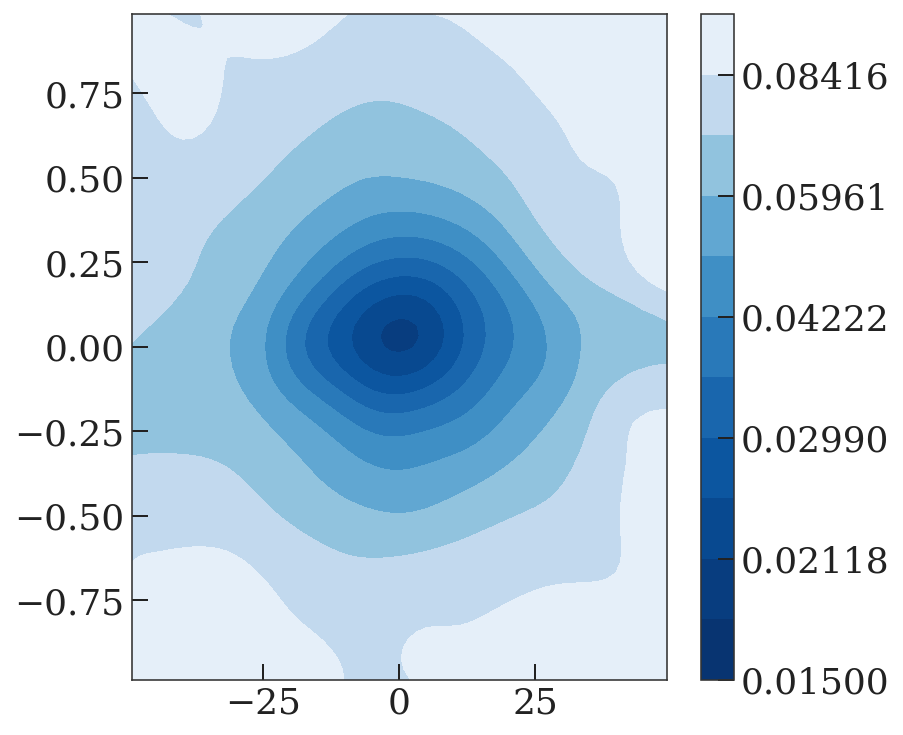

In [264]:
# plt.pcolormesh(
#     stat.x_edge,
#     stat.y_edge,
#     convolve(stat.statistic.T, Gaussian2DKernel(3.0), boundary="extend"),
#     vmin=0,
#     vmax=0.15,
# )

nsigma = 3.2
print(nsigma * np.diff(stat.x_edge)[0], nsigma * np.diff(stat.y_edge)[0])

H = stat.statistic.T.copy()
H[counts.T < 8] = np.nan

plt.contourf(
    0.5 * (stat.x_edge[:-1] + stat.x_edge[1:]),
    0.5 * (stat.y_edge[:-1] + stat.y_edge[1:]),
    convolve(H, Gaussian2DKernel(nsigma), boundary="extend"),
    #     levels=np.linspace(0, 0.15, 16)
    levels=np.geomspace(0.015, 0.1, 12),
    cmap="Blues_r",
)
plt.colorbar()

---

In [101]:
# xiang = GaiaData("/mnt/home/apricewhelan/data/misc/XiangRix2022-subgiants-joined-gaiadr3.fits")
xiang = at.Table.read(
    "/mnt/home/apricewhelan/data/misc/XiangRix2022-subgiants-fullparam.fits"
)
for col in xiang.colnames:
    xiang.rename_column(col, col.lower())
xiang = GaiaData(xiang)

In [125]:
# Gaia RVs
# xiang = xiang.filter(parallax=(0*u.mas, None), radial_velocity=(-900, 900)*u.km/u.s)

# LAMOST RVs
xiang = xiang.filter(
    parallax=(0 * u.mas, None), vlos=(-900, 900), feh=(-0.8, 0.5), alpha_fe=(-0.1, 0.15)
)

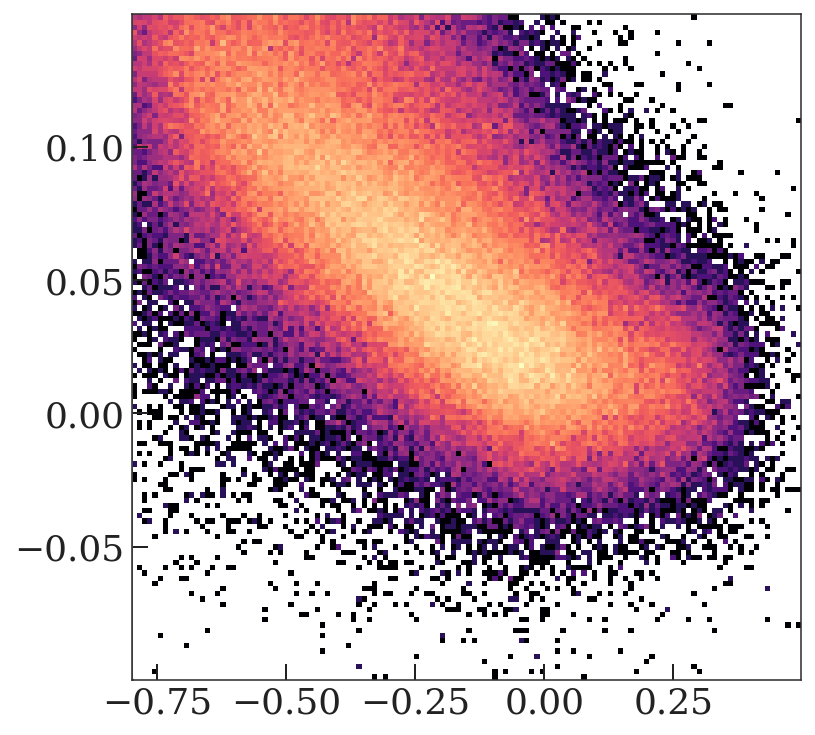

In [126]:
plt.hist2d(xiang.feh, xiang.alpha_fe, bins=128, norm=mpl.colors.LogNorm())
plt.axvline(-0.8)
plt.axhline(0.2)

In [127]:
c_xiang = xiang.get_skycoord(radial_velocity=xiang.vlos * u.km / u.s)

In [128]:
galcen_xiang = c_xiang.transform_to(galcen_frame)
w_xiang = gd.PhaseSpacePosition(galcen_xiang.data)

In [149]:
Lz = np.abs(w_xiang.angular_momentum()[2]).to(u.kpc * u.km / u.s)
Lz_mask_xiang = np.abs(Lz - Lz_sun) < 0.2 * Lz_sun
Lz_mask_xiang.sum()

128017

In [150]:
bins = (np.linspace(-100, 100, 128), np.linspace(-2.5, 2.5, 128))

stat_x_age = binned_statistic_2d(
    galcen_xiang.v_z.to_value(u.km / u.s)[Lz_mask_xiang],
    galcen_xiang.z.to_value(u.kpc)[Lz_mask_xiang],
    xiang.age[Lz_mask_xiang],
    bins=bins,
)

stat_x_alpha = binned_statistic_2d(
    galcen_xiang.v_z.to_value(u.km / u.s)[Lz_mask_xiang],
    galcen_xiang.z.to_value(u.kpc)[Lz_mask_xiang],
    xiang.alpha_fe[Lz_mask_xiang],
    bins=bins,
)

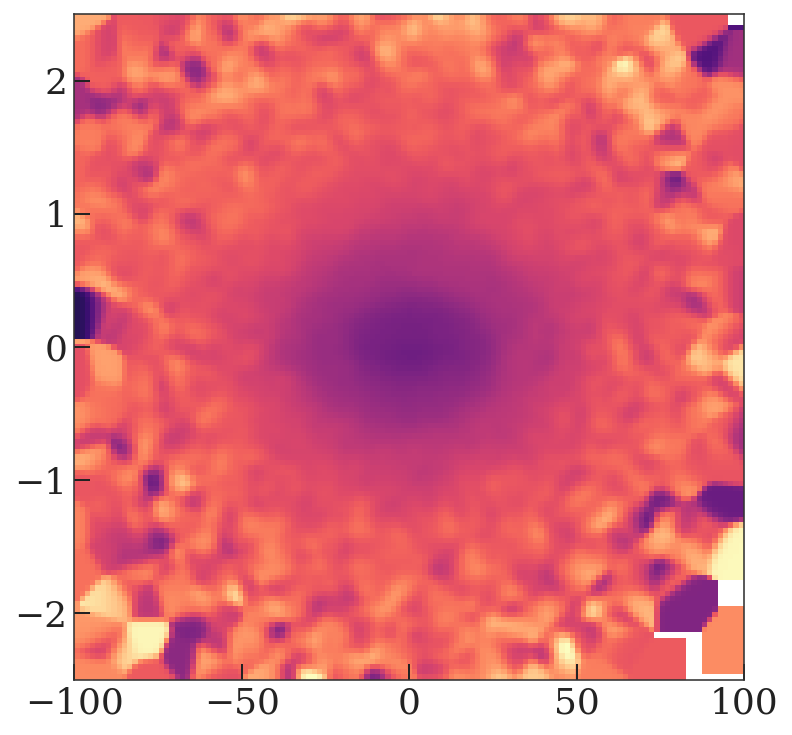

In [178]:
plt.pcolormesh(
    stat_x_age.x_edge,
    stat_x_age.y_edge,
    convolve(stat_x_age.statistic.T, Gaussian2DKernel(1.5), boundary="extend"),
    vmin=0,
    vmax=14,
)

# plt.contourf(
#     0.5 * (stat_x_age.x_edge[:-1] + stat_x_age.x_edge[1:]),
#     0.5 * (stat_x_age.y_edge[:-1] + stat_x_age.y_edge[1:]),
#     convolve(stat_x_age.statistic.T, Gaussian2DKernel(2.0), boundary="extend"),
#     levels=np.linspace(0, 14, 12)
# )

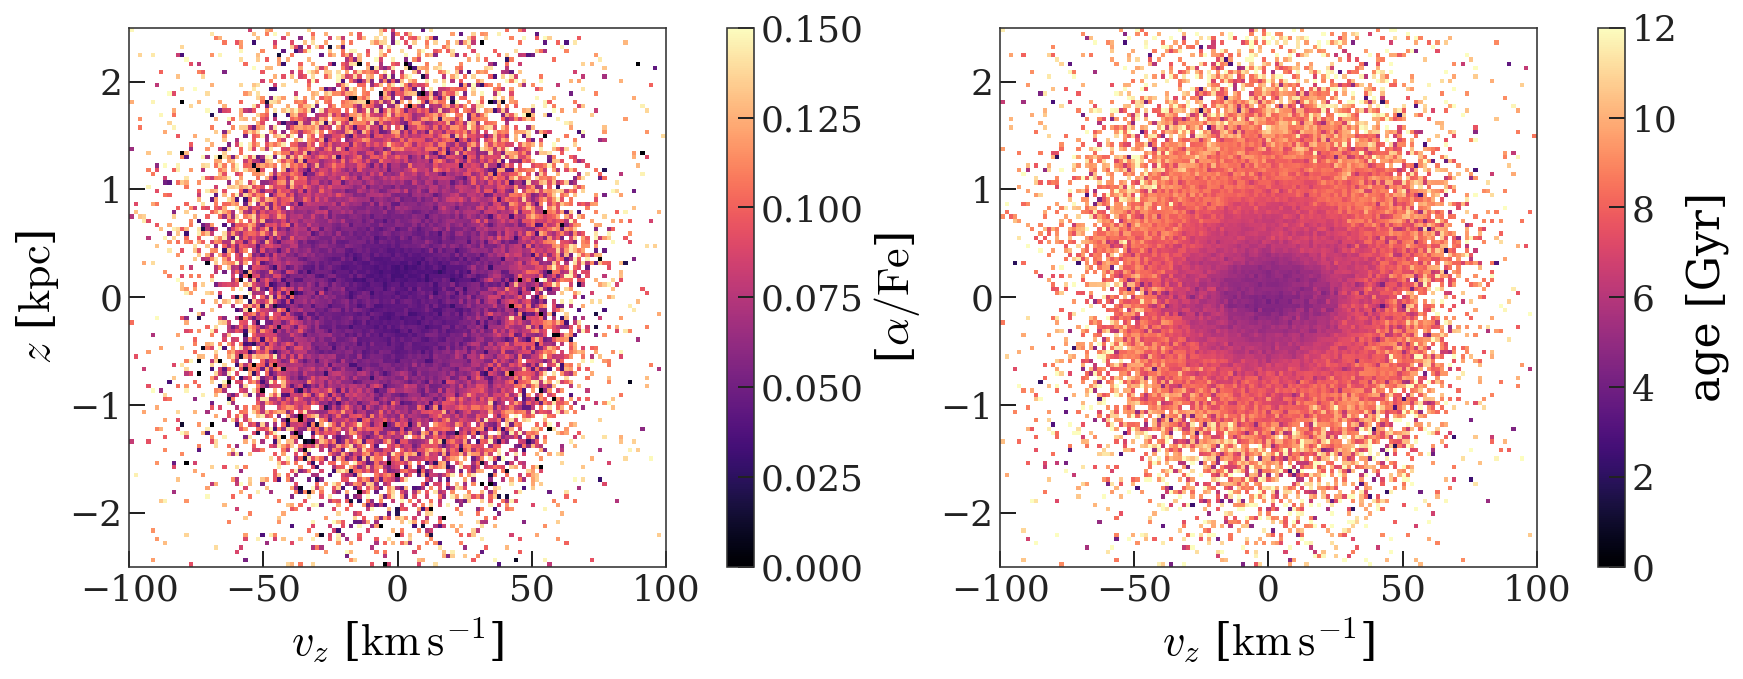

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), constrained_layout=True)

cs = axes[0].pcolormesh(
    stat_x.x_edge, stat_x.y_edge, stat_x_alpha.statistic.T, vmin=0, vmax=0.15
)
cb = fig.colorbar(cs, ax=axes[0])
cb.set_label(r"[$\alpha/{\rm Fe}$]")

cs = axes[1].pcolormesh(
    stat_x.x_edge, stat_x.y_edge, stat_x_age.statistic.T, vmin=0, vmax=12
)
cb = fig.colorbar(cs, ax=axes[1])
cb.set_label("age [Gyr]")

axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")